In [1]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss, matthews_corrcoef, precision_recall_curve, auc
import pickle
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import datetime
from collections import defaultdict, Counter

import sys
sys.path.append('../../')

# utils
from common_utils.logger import init_logger
from common_utils.settings import cfg_init
from common_utils.kf import get_fold
# from common_utils.gbdt.model_gbdt import LightGBM, CatBoost
# from common_utils.gbdt.model_gbdt import LightGBM
from common_utils.feature_engineering.base import run_block, NumericBlock, LabelEncodingBlock, CountEncodingBlock, AggBlock, TargetEncodingBlock
from common_utils.feature_engineering.text import TextLenBlock, TfidfSVDBlock

/home/ryosuke/.cache/pypoetry/virtualenvs/kaggle-pipeline-atmacup-16-kgwzrA72-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from myutils.metrics import mapk

In [3]:
from common_utils.metrics import calc_auc_score

In [4]:
class CFG:
    # ============== comp exp name =============
    comp_name = 'atmacup_16'

    comp_dir_path = '../../'
    comp_folder_name = 'atmaCup16_Dataset'  # compのデータセットのフォルダ名
    comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'

    try:
        exp_name = os.path.basename(__file__).split('.')[0]
    except Exception:
        print('running kernel')
        exp_name = None
    
    exp_name = 'train_gbdt_1stage_training_exp002' # notebook
    feature_notebook_name = 'train_gbdt_1stage_feature_only_exp001'

    # ============== model =============
    model_name = 'catboost_gkf'

    # ============== features =============
    catboost_cat_cols = []
    catboost_text_cols = []
    top_k = 40
    # ============== pred target =============
    # target_col = 'target'
    target_col = 'target_multi'

    target_size = 1
    num_class = 5 # multiclassの場合

    # ============== fold =============
    n_fold = 5
    skf_col = 'session_id'
    # group_col = 'session_id'
    group_col = 'session_duplicated_group'
    fold_type = 'gkf'

    objective_cv = 'binary'  # collateとかの型を決める用
    metric_direction = 'maximize'  # gbdtだと使わない
    metrics = 'calc_auc_score'

    # ============== wandb =============
    wandb_note = f'starter'

    # ============== ほぼ固定 =============
    seed = 42

    # ============== set dataset path =============
    if exp_name is not None:
        print('set dataset path')

        outputs_path = comp_dir_path +  \
            f'outputs/{comp_name}/{exp_name}/'

        submission_dir = outputs_path + 'submissions/'
        submission_path = submission_dir + f'submission_{exp_name}.csv'

        model_dir = outputs_path + \
            f'{comp_name}-models/'

        figures_dir = outputs_path + 'figures/'

        log_dir = outputs_path + 'logs/'
        log_path = log_dir + f'{exp_name}.txt'

running kernel
set dataset path


## todo 

last_itemと同じ候補は取り除く

In [5]:
warnings.filterwarnings('ignore')

cfg_init(CFG)

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------
2023年12月16日 18:06:14


In [6]:
import lightgbm as lgb
from catboost import Pool, CatBoostClassifier, CatBoostRegressor
import catboost
import pandas as pd
import matplotlib.pyplot as plt
import pickle


class LightGBM:

    def __init__(self, lgb_params, save_dir=None, imp_dir=None, categorical_feature=None,
                 model_name='lgb',
                 stopping_rounds=50) -> None:
        self.save_dir = save_dir
        self.imp_dir = imp_dir
        self.lgb_params = lgb_params
        self.categorical_feature = categorical_feature

        # saveの切り替え用
        self.model_name = model_name

        self.stopping_rounds = stopping_rounds

    def fit(self, x_train, y_train, train_group, val_group, **fit_params) -> None:

        X_val, y_val = fit_params['eval_set'][0]
        del fit_params['eval_set']

        print('make dataset')
        train_dataset = lgb.Dataset(
            x_train, y_train, group=train_group, categorical_feature=self.categorical_feature)

        val_dataset = lgb.Dataset(
            X_val, y_val, group=val_group, categorical_feature=self.categorical_feature)

        print('start training')
        self.model = lgb.train(params=self.lgb_params,
                               train_set=train_dataset,
                               valid_sets=[train_dataset, val_dataset],
                               callbacks=[lgb.early_stopping(stopping_rounds=self.stopping_rounds,
                                                             verbose=True),
                                          lgb.log_evaluation(50)],
                               **fit_params
                               )

    def plot_importance(self, fold):
        gain_importances = pd.DataFrame({'Feature': self.model.feature_name(),
                                         'Importance': self.model.feature_importance(importance_type='gain')})

        gain_importances.to_csv(
            f'{self.imp_dir}lgb_imp_fold_{fold}_{self.model_name}.csv', index=False)

        gain_importances = gain_importances.nlargest(
            50, 'Importance', keep='first').sort_values(by='Importance', ascending=True)

        gain_importances[['Importance', 'Feature']].plot(
            kind='barh', x='Feature', color='blue', figsize=(12, 8), fontsize=9)
        # plt.ylabel('Feature', fontsize=12)
        plt.title(f'gain importance fold {fold}')
        plt.savefig(
            f'{self.imp_dir}gain_importance_fold{fold}_{self.model_name}.png', bbox_inches='tight')

    def plot_importance_all(self, n_fold=5):
        dfs = [pd.read_csv(
            f'{self.imp_dir}lgb_imp_fold_{fold}_{self.model_name}.csv') for fold in range(n_fold)]
        imp_df = pd.concat(dfs).reset_index(drop=True)
        imp_df = imp_df.groupby(['Feature'])['Importance'].mean().reset_index()

        gain_importances = imp_df.nlargest(
            50, 'Importance', keep='first').sort_values(by='Importance', ascending=True)
        gain_importances[['Importance', 'Feature']].plot(
            kind='barh', x='Feature', color='blue', figsize=(12, 8), fontsize=9)
        plt.title('gain importance all')
        plt.savefig(
            f'{self.imp_dir}gain_importance_all_{self.model_name}.png', bbox_inches='tight')

        return imp_df

    def save(self, fold):
        save_to = f'{self.save_dir}lgb_fold_{fold}_{self.model_name}.txt'
        self.model.save_model(save_to)

    def load(self, fold):
        load_from = f'{self.save_dir}lgb_fold_{fold}_{self.model_name}.txt'
        self.model = lgb.Booster(model_file=load_from)

    def predict(self, x):
        return self.model.predict(x)

    def predict_proba(self, x):
        return self.model.predict_proba(x)

In [7]:
import lightgbm as lgb
from catboost import Pool, CatBoostClassifier, CatBoostRegressor
import catboost
import pandas as pd
import matplotlib.pyplot as plt
import pickle

class CatBoost:

    def __init__(self, lgb_params, mode, save_dir=None, imp_dir=None, categorical_feature=None, text_features=None,
                 model_name='catboost') -> None:
        self.mode = mode
        self.save_dir = save_dir
        self.imp_dir = imp_dir
        self.lgb_params = lgb_params
        self.categorical_feature = categorical_feature
        self.text_features = text_features

        # saveの切り替え用
        self.model_name = model_name

    def fit(self, x_train, y_train, train_group, val_group, **fit_params) -> None:

        print('categorical feature')
        print(self.categorical_feature)

        print('text feature')
        print(self.text_features)

        X_val, y_val = fit_params['eval_set'][0]
        del fit_params['eval_set']

        train_pool = Pool(x_train, y_train, text_features=self.text_features,
                          cat_features=self.categorical_feature,
                          group_id=train_group)
        val_pool = Pool(X_val, y_val, text_features=self.text_features,
                        cat_features=self.categorical_feature,
                        group_id=val_group)

        """
        if self.mode == 'regression':
            self.model = CatBoostRegressor(**self.lgb_params)
        else:
            self.model = CatBoostClassifier(**self.lgb_params)
        """
        self.model = catboost.CatBoost(self.lgb_params)        

        self.model.fit(train_pool,
                       eval_set=val_pool,
                       **fit_params
                       )
        self.gain_importances = pd.DataFrame({'Feature': self.model.feature_names_,
                                              'Importance': self.model.get_feature_importance(train_pool)})


    def plot_importance(self, fold):
        """
        gain_importances = pd.DataFrame({'Feature': self.model.feature_names_,
                                         'Importance': self.model.feature_importances_})
        """
        # rerankerだとNoneになる
        # print(self.model.feature_importances_)
        gain_importances = self.gain_importances

        gain_importances.to_csv(
            f'{self.imp_dir}catboost_imp_fold_{fold}_{self.model_name}.csv', index=False)

        gain_importances = gain_importances.nlargest(
            50, 'Importance', keep='first').sort_values(by='Importance', ascending=True)
        gain_importances[['Importance', 'Feature']].plot(
            kind='barh', x='Feature', color='blue', figsize=(12, 8), fontsize=9)

        # plt.ylabel('Feature', fontsize=12)
        plt.title(f'gain importance fold {fold}')
        plt.savefig(
            f'{self.imp_dir}gain_importance_fold{fold}_{self.model_name}.png', bbox_inches='tight')

    def plot_importance_all(self, n_fold=5):
        dfs = [pd.read_csv(
            f'{self.imp_dir}catboost_imp_fold_{fold}_{self.model_name}.csv') for fold in range(n_fold)]
        imp_df = pd.concat(dfs).reset_index(drop=True)
        imp_df = imp_df.groupby(['Feature'])['Importance'].mean().reset_index()

        gain_importances = imp_df.nlargest(
            50, 'Importance', keep='first').sort_values(by='Importance', ascending=True)
        gain_importances[['Importance', 'Feature']].plot(
            kind='barh', x='Feature', color='blue', figsize=(12, 8), fontsize=9)
        plt.title('gain importance all')
        plt.savefig(
            f'{self.imp_dir}gain_importance_all_{self.model_name}.png', bbox_inches='tight')

        return imp_df
    
    def save(self, fold):
        save_to = f'{self.save_dir}catboost_fold_{fold}_{self.model_name}.pkl'
        pickle.dump(self.model, open(save_to, 'wb'))
    
    def load(self, fold):
        load_from = f'{self.save_dir}catboost_fold_{fold}_{self.model_name}.pkl'
        self.model = pickle.load(open(load_from, 'rb'))
        
    def predict(self, x):
        return self.model.predict(x)

    def predict_proba(self, x):
        return self.model.predict_proba(x)
        # return self.model.predict(x, prediction_type='Probability')[:, 1]


In [8]:
def get_model(model_name):
    if 'lgb' in model_name:
        """
        適宜追加: 
        'metric': 'rmse',
        """
        """
        lgb_params = {'objective': CFG.objective_cv, 'boosting_type': 'gbdt', 'verbose': -1,
                    'n_jobs': 8, 'seed': CFG.seed, 'learning_rate': 0.1,
                    # 'num_class': CFG.num_class, # multiclassなら必要
                    'metric': 'auc',
                    'num_leaves': 64,
                    'max_depth': 5,
                    'bagging_seed': CFG.seed,
                    'feature_fraction_seed': CFG.seed,
                    'drop_seed': CFG.seed,
                    }
        """

        lgb_params = {'objective': 'lambdarank', 'boosting_type': 'gbdt', 'verbose': -1,
                    'n_jobs': 8, 'seed': CFG.seed, 'learning_rate': 0.1,
                    # 'num_class': CFG.num_class, # multiclassなら必要
                    # 'metric': 'map',
                    'num_leaves': 64,
                    'max_depth': 5,
                    'bagging_seed': CFG.seed,
                    'feature_fraction_seed': CFG.seed,
                    'drop_seed': CFG.seed,
                    # "eval_at": 10,
                    }
        
        """
        lgb_params = {'objective': 'xendcg', 'boosting_type': 'gbdt', 'verbose': -1,
                    'n_jobs': 8, 'seed': CFG.seed, 
                    'learning_rate': 0.1,
                    # 'num_leaves': 255,
                    # 'min_data_in_leaf': 100,
                    'bagging_seed': CFG.seed,
                    'feature_fraction_seed': CFG.seed,
                    'drop_seed': CFG.seed,
                    # "eval_at": 10,
                    }
        """
        model = LightGBM(lgb_params=lgb_params,
                        imp_dir=CFG.figures_dir, save_dir=CFG.model_dir,
                        model_name=model_name)
    elif 'catboost' in model_name:
        """
        追加予定: 
        'loss_function': 'RMSE', 'task_type': 'GPU',
        """
        lgb_params = {
                    # 'random_seed': CFG.seed, 
                    'iterations': 10000,
                    'loss_function': 'YetiRank',
                    # 'loss_function': 'PairLogitPairwise',
                    'task_type': 'GPU',
                    # 'learning_rate': 0.1, # YetiRank gpuのときは設定しない
                    "random_state": 42,
                    }
        if lgb_params['loss_function'] == 'PairLogitPairwise':
            lgb_params['learning_rate'] = 0.1
            lgb_params['iterations'] = 100000

        model = CatBoost(lgb_params=lgb_params,
                         mode = CFG.objective_cv,
                         imp_dir=CFG.figures_dir, save_dir=CFG.model_dir,
                         model_name=model_name,
                         categorical_feature=CFG.catboost_cat_cols,
                         text_features=CFG.catboost_text_cols)       


    return model

In [9]:
def get_fit_params(model_name):
    if 'lgb' in model_name:
        params = {
            'num_boost_round': 100000
        }
        # 'stopping_rounds': 50, # 'early_stopping_rounds': 50,
        #         'verbose_eval': 50
    elif 'catboost' in model_name:
        params = {
            'early_stopping_rounds': 50,
            'verbose': 50,
            'use_best_model': True,
        }
        
    return params

In [10]:
def get_result(result_df):

    pred_cols = [f'pred_{i}' for i in range(CFG.target_size)]

    preds = result_df[pred_cols].values
    labels = result_df[CFG.target_col].values

    eval_func = eval(CFG.metrics)
    best_score = eval_func(labels, preds)

    Logger.info(f'best_score: {best_score:<.4f}')
    return best_score


In [11]:
train_log_df = pd.read_csv(CFG.comp_dataset_path + 'train_log.csv')
train_label_df = pd.read_csv(CFG.comp_dataset_path + 'train_label.csv')
test_log_df = pd.read_csv(CFG.comp_dataset_path + 'test_log.csv')
yado_df = pd.read_csv(CFG.comp_dataset_path + 'yado.csv')

train_session_only_df = train_label_df[['session_id']]
test_session_only_df = pd.read_csv(CFG.comp_dataset_path + 'test_session.csv')

train_test_log_df = pd.concat([train_log_df, test_log_df], axis=0).reset_index(drop=True)

In [12]:
train_df = pd.read_pickle(f'../../outputs/atmacup_16/{CFG.feature_notebook_name}/feature_pkl/train_df.pkl')
num_cols = pickle.load(open(f'../../outputs/atmacup_16/{CFG.feature_notebook_name}/feature_pkl/num_cols.pkl', 'rb'))

In [13]:
# train_df[train_df['last_item'] == 2808].sort_values(['session_id', 'yad_no']).to_csv('last_item_2808.csv', index=False)

In [14]:
def add_multi_target_label(train_df, train_log_df):
    train_log_last_df = train_log_df.copy()
    train_log_last_df['session_length'] = train_log_last_df.groupby('session_id').transform('size')
    train_log_last_df = train_log_last_df[train_log_last_df['session_length'] == 1].reset_index(drop=True)

    train_log_last_df = train_log_last_df.rename(columns={'yad_no': 'last_item'})
    train_log_last_df = train_log_last_df.merge(train_label_df, on='session_id', how='left')

    dup_count_df = train_log_last_df.groupby('last_item').size().rename('dup_count')
    plt.hist(dup_count_df, bins=100)
    plt.title('dup count hist')
    plt.show()

    last_item_to_reserve_yado = train_log_last_df.groupby('last_item')['yad_no'].apply(list).to_dict()
    last_item_to_reserve_yado_dict = defaultdict(set)
    for k, items in last_item_to_reserve_yado.items():
        for v in items:
            last_item_to_reserve_yado_dict[k].add(v)

    results = []
    for last_item, yad_no in train_df[['last_item', 'yad_no']].values:
        if yad_no in last_item_to_reserve_yado_dict[last_item]:
            results.append(1)
        else:
            results.append(0)
    train_df['target_multi'] = results
    print(train_df['target_multi'].value_counts())

    # sessionの長さが1より大きい場合は元のラベルを使う
    train_log_last_df['is_session_length_1'] = 1
    train_df = pd.merge(train_df, train_log_last_df[['session_id', 'is_session_length_1']], on='session_id', how='left')
    train_df['is_session_length_1'] = train_df['is_session_length_1'].fillna(0).astype(int)
    
    fill_ori_label_idxs = train_df['is_session_length_1'] == 0
    train_df.loc[fill_ori_label_idxs, 'target_multi'] = train_df.loc[fill_ori_label_idxs, 'target']

    print(train_df['target'].value_counts())
    print(train_df['target_multi'].value_counts())

    # add duplicated label
    train_df_last_item = train_df[train_df['is_session_length_1'] == 1]
    duplicated_idxs = train_df_last_item[['last_item', 'yad_no']].duplicated()
    duplicated_idxs = duplicated_idxs[duplicated_idxs].index
    train_df.loc[duplicated_idxs, 'is_duplicated'] = 1
    train_df['is_duplicated'] = train_df['is_duplicated'].fillna(0).astype(int)
    print(train_df.groupby(['is_session_length_1', 'is_duplicated']).size().reset_index())

    return train_df


In [15]:
def add_multi_target_label_all_data(train_df, train_log_df, train_label_df):
    # session_idごとの、logのyad
    session_to_log_yad_dict = train_log_df.groupby('session_id')['yad_no'].apply(tuple).to_dict()
    session_to_true_yad_dict = dict(zip(train_label_df['session_id'], train_label_df['yad_no']))

    # session内のyad_noのリストを、実際に予約されたyad_noのリストに変換
    log_yad_list_to_true_yad_dict = defaultdict(set)
    for session_id, yad_tuple in session_to_log_yad_dict.items():
        true_yad = session_to_true_yad_dict[session_id]
        log_yad_list_to_true_yad_dict[yad_tuple].add(true_yad)

    results = []
    is_duplicates = []
    seen = set()
    for session_id, yad_no in train_df[['session_id', 'yad_no']].values:
        session_log_yads = session_to_log_yad_dict[session_id]
        true_yad_set = log_yad_list_to_true_yad_dict[session_log_yads]
        if yad_no in true_yad_set:
            results.append(1)
        else:
            results.append(0)
        # ログのyadの系列に、今回のyad_noを追加して、重複があるかどうかを判定
        if tuple(list(session_log_yads) + [yad_no]) in seen:
            is_duplicates.append(1)
        else:
            is_duplicates.append(0)
            seen.add(tuple(list(session_log_yads) + [yad_no]))
        
    train_df['target_multi'] = results
    train_df['is_duplicated'] = is_duplicates
    
    print(train_df['target_multi'].value_counts())

    # debug用
    session_length_df = train_log_df.groupby('session_id').size().rename('session_length').reset_index()
    train_df = pd.merge(train_df, session_length_df, on='session_id', how='left')

    train_df['is_session_length_1'] = (train_df['session_length'] == 1).astype(int)

    print(train_df['target'].value_counts())
    print(train_df['target_multi'].value_counts())

    print(train_df.groupby(['is_duplicated']).size().reset_index())

    print(train_df.groupby(['session_length', 'is_duplicated']).size().reset_index())

    return train_df


In [16]:
# train_df = add_multi_target_label(train_df, train_log_df)
train_df = add_multi_target_label_all_data(train_df, train_log_df, train_label_df)

target_multi
0    22240152
1     5901523
Name: count, dtype: int64
target
0    27863990
1      277685
Name: count, dtype: int64
target_multi
0    22240152
1     5901523
Name: count, dtype: int64
   is_duplicated         0
0              0   8842660
1              1  19299015
    session_length  is_duplicated         0
0                1              0    994518
1                1              1  17944405
2                2              0   6285904
3                2              1   1237874
4                3              0   1163501
5                3              1    103458
6                4              0    306426
7                4              1     12531
8                5              0     68589
9                5              1       747
10               6              0     17163
11               7              0      5009
12               8              0      1233
13               9              0       275
14              10              0        42


In [17]:
def add_session_duplicated_group(train_df, train_log_df):
    # session_idごとの、logのyad
    session_to_log_yad_dict = train_log_df.groupby('session_id')['yad_no'].apply(tuple).to_dict()

    # session内のyad_noの組み合わせが同じsessionを同じグループとする
    log_yads_to_group_num_dict = {}
    group_count = 0
    for session_id, session_log_yads in session_to_log_yad_dict.items():
        if session_log_yads in log_yads_to_group_num_dict:
            pass
        else:
            group_count += 1
            log_yads_to_group_num_dict[session_log_yads] = group_count

    group_list = []
    for session_id, yad_no in train_df[['session_id', 'yad_no']].values:
        session_log_yads = session_to_log_yad_dict[session_id]
        group_list.append(log_yads_to_group_num_dict[session_log_yads])
        
    train_df['session_duplicated_group'] = group_list

    return train_df


In [18]:
train_df = add_session_duplicated_group(train_df, train_log_df)

In [19]:
train_df['session_id'].nunique(), train_df['session_duplicated_group'].nunique()

(288698, 100379)

In [20]:
for num in range(1, 6):
    train_df[train_df['session_duplicated_group'] == num].sort_values(['session_id', 'yad_no']).to_csv(CFG.outputs_path + 'train_df_session_duplicated_group_1.csv', index=False)

In [21]:
train_df = get_fold(train_df, CFG)

fold
0    5628336
1    5628336
2    5628336
3    5628332
4    5628335
dtype: int64


In [22]:
set(train_df[train_df['fold'] == 0]['session_duplicated_group']) & set(train_df[train_df['fold'] != 0]['session_duplicated_group'])

set()

In [23]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
        
        # print(str(col_type))
        if col_type != object and str(col_type) != 'datetime64[ns]':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            # df[col] = df[col].astype('category')
            pass
            
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(
        100 * (start_mem - end_mem) / start_mem))

    return df


In [24]:
print(train_df.dtypes)

session_id                          object
yad_no                               int64
rank_past_item                     float64
candidate_name                      object
true_yad_no                          int64
target                               int64
candidate_name_num                   int64
all_zero_flag                        int64
last_item                            int64
fold                                 int64
total_room_cnt                     float64
sml_cd                              object
lrg_cd                              object
total_room_cnt_last_item           float64
sml_cd_last_item                    object
lrg_cd_last_item                    object
last_item_is_same_sml_cd             int64
last_item_is_same_lrg_cd             int64
last_item_coo_count_1                int64
last_item_coo_count_2                int64
last_item_coo_count_3                int64
last_item_coo_count_4                int64
last_item_coo_count_1_rank           int64
last_item_c

In [25]:
train_df.dtypes.to_csv(CFG.outputs_path + 'train_df_dtypes.csv')

In [26]:
# train_df[num_cols] = reduce_mem_usage(train_df[num_cols])
gc.collect()

0

In [27]:
del_col = ['sml_cd', 'lrg_cd', 'sml_cd_last_item', 'lrg_cd_last_item', 'candidate_name']
train_df.drop(del_col, axis=1, inplace=True)
gc.collect()

0

In [28]:
train_df.dtypes.to_csv(CFG.outputs_path + 'train_df_dtypes_mem_usage.csv')

In [29]:
train_null_df = train_df[num_cols].isnull().sum()
print(train_null_df)
train_null_df.to_csv(CFG.outputs_path + 'train_null.csv')

total_room_cnt                      1482005
last_item_is_same_sml_cd                  0
last_item_is_same_lrg_cd                  0
rank_past_item                     28032222
yad_occur_count                      212348
yad_session_nunique                  212348
yad_occur_rank_sml_cd                     0
yad_occur_rank_wid_cd                     0
yad_occur_rank_ken_cd                     0
yad_occur_rank_lrg_cd                     0
session_item_count                        0
session_item_nunique                      0
last_item_coo_count_1                     0
last_item_coo_count_2                     0
last_item_coo_count_3                     0
last_item_coo_count_4                     0
last_item_coo_count_1_rank                0
last_item_coo_count_2_rank                0
last_item_coo_count_3_rank                0
last_item_coo_count_4_rank                0
cos_sim_node2vec_all_item                 0
cos_sim_node2vec_last_item                0
cos_sim_prone_all_item          

In [30]:
def train_fold(train_df, y, num_cols, fold, folds, model_name):
    model = get_model(model_name)

    trn_ind = (folds != fold)
    val_ind = folds == fold

    print('loc')
    x_train, x_val = train_df.loc[trn_ind, num_cols], train_df.loc[val_ind, num_cols]
    y_train, y_val = y.loc[trn_ind], y.loc[val_ind]
    eval_set = [(x_val, y_val)]

    print('group')
    if 'lgb' in model_name:
        train_group, val_group = train_df.loc[trn_ind].groupby('session_id').size().values, train_df.loc[val_ind].groupby('session_id').size().values
    elif 'catboost' in model_name:
        train_group, val_group = train_df.loc[trn_ind]['session_id'].values, train_df.loc[val_ind]['session_id'].values

    print(len(x_train), len(x_val))

    fit_params_fold = get_fit_params(model_name)
    fit_params_fold['eval_set'] = eval_set

    print('model fit start')
    
    if 'lgb' in model_name:
        # binary
        # model.fit(x_train, y_train, **fit_params_fold)
        # ranker
        model.fit(x_train, y_train, train_group, val_group, **fit_params_fold)
    elif 'catboost' in model_name:
        # ranker
        model.fit(x_train, y_train, train_group, val_group, **fit_params_fold)

    print('save model')
    if hasattr(model, 'save'):
        model.save(fold)
    if hasattr(model, 'plot_importance'):
        model.plot_importance(fold)

    print('val predict start')
    # oof_predictions[val_ind] = model.predict(x_val).reshape(-1, 1)
    oof_preds = model.predict(x_val).reshape(-1, 1)
    return oof_preds, val_ind

def train(train_df, num_cols):
    y = train_df[CFG.target_col]
    folds = train_df['fold']

    model_name = CFG.model_name

    eval_func = eval(CFG.metrics)

    oof_predictions = np.zeros((train_df.shape[0], CFG.target_size))
    # test_predictions = np.zeros(test_df.shape[0])

    for fold in range(CFG.n_fold):
        Logger.info(f'Training fold {fold + 1}')

        oof_preds, val_ind = train_fold(train_df, y, num_cols, fold, folds, model_name)
        oof_predictions[val_ind] = oof_preds

        gc.collect()

    # score = eval_func(y, oof_predictions)
    # Logger.info(f'oof result {score}')

    model = get_model(model_name)
    if hasattr(model, 'plot_importance_all'):
        model.plot_importance_all(n_fold=CFG.n_fold)

    pred_cols = [f'pred_{i}' for i in range(CFG.target_size)]
    train_df[pred_cols] = oof_predictions
    train_df[CFG.target_col] = y

    return train_df

In [31]:
def inference(test_df, num_cols):
    model_name = CFG.model_name
    test_predictions = np.zeros(test_df.shape[0])

    model = get_model(model_name)

    for fold in range(CFG.n_fold):
        Logger.info(f'inference fold {fold + 1}')
        model.load(fold)
        test_predictions += model.predict(test_df[num_cols])

    test_predictions /= CFG.n_fold
    test_df[CFG.target_col] = test_predictions
    return test_df

Training fold 1


loc
group
22513339 5628336
model fit start
categorical feature
[]
text feature
[]


Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7176177	best: 0.7176177 (0)	total: 290ms	remaining: 48m 22s
50:	test: 0.9851057	best: 0.9851057 (50)	total: 12.4s	remaining: 40m 26s
100:	test: 0.9861434	best: 0.9861731 (98)	total: 24.9s	remaining: 40m 41s
150:	test: 0.9873408	best: 0.9873417 (149)	total: 37.7s	remaining: 40m 58s
200:	test: 0.9875639	best: 0.9875667 (186)	total: 50.5s	remaining: 41m 3s
250:	test: 0.9877354	best: 0.9877781 (229)	total: 1m 3s	remaining: 40m 59s
300:	test: 0.9879392	best: 0.9879392 (300)	total: 1m 16s	remaining: 40m 51s
350:	test: 0.9884835	best: 0.9885039 (340)	total: 1m 28s	remaining: 40m 42s
400:	test: 0.9889389	best: 0.9889408 (396)	total: 1m 41s	remaining: 40m 35s
450:	test: 0.9891872	best: 0.9891882 (446)	total: 1m 54s	remaining: 40m 26s
500:	test: 0.9893966	best: 0.9894064 (494)	total: 2m 7s	remaining: 40m 17s
550:	test: 0.9895250	best: 0.9895535 (548)	total: 2m 20s	remaining: 40m 7s
600:	test: 0.9896753	best: 0.9896753 (600)	total: 2m 33s	remaining: 40m
650:	test: 0.9897781	best: 0.989

Training fold 2


loc
group
22513339 5628336
model fit start
categorical feature
[]
text feature
[]


Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7707547	best: 0.7707547 (0)	total: 266ms	remaining: 44m 14s
50:	test: 0.9844731	best: 0.9844731 (50)	total: 12.6s	remaining: 40m 58s
100:	test: 0.9853862	best: 0.9853944 (81)	total: 25.2s	remaining: 41m 6s
150:	test: 0.9861609	best: 0.9861769 (148)	total: 37.9s	remaining: 41m 12s
200:	test: 0.9863962	best: 0.9864300 (190)	total: 50.7s	remaining: 41m 14s
250:	test: 0.9865701	best: 0.9865701 (249)	total: 1m 3s	remaining: 41m 3s
300:	test: 0.9866262	best: 0.9866500 (292)	total: 1m 16s	remaining: 40m 49s
350:	test: 0.9871949	best: 0.9872072 (346)	total: 1m 28s	remaining: 40m 36s
400:	test: 0.9875203	best: 0.9875203 (400)	total: 1m 41s	remaining: 40m 24s
450:	test: 0.9878328	best: 0.9878328 (450)	total: 1m 53s	remaining: 40m 13s
500:	test: 0.9880269	best: 0.9880269 (500)	total: 2m 6s	remaining: 40m 5s
550:	test: 0.9881100	best: 0.9881100 (550)	total: 2m 19s	remaining: 39m 55s
600:	test: 0.9882223	best: 0.9882549 (596)	total: 2m 32s	remaining: 39m 48s
650:	test: 0.9882844	best: 0.

Training fold 3


loc
group
22513339 5628336
model fit start
categorical feature
[]
text feature
[]


Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7373845	best: 0.7373845 (0)	total: 275ms	remaining: 45m 51s
50:	test: 0.9855346	best: 0.9855346 (50)	total: 12.5s	remaining: 40m 40s
100:	test: 0.9866043	best: 0.9866043 (100)	total: 24.9s	remaining: 40m 45s
150:	test: 0.9865910	best: 0.9866724 (113)	total: 37.5s	remaining: 40m 49s
200:	test: 0.9877665	best: 0.9877665 (200)	total: 50.2s	remaining: 40m 49s
250:	test: 0.9878968	best: 0.9879009 (237)	total: 1m 2s	remaining: 40m 42s
300:	test: 0.9879268	best: 0.9879930 (258)	total: 1m 15s	remaining: 40m 37s
350:	test: 0.9884498	best: 0.9885188 (344)	total: 1m 28s	remaining: 40m 29s
400:	test: 0.9887079	best: 0.9887173 (396)	total: 1m 41s	remaining: 40m 21s
450:	test: 0.9889637	best: 0.9890499 (440)	total: 1m 54s	remaining: 40m 14s
500:	test: 0.9891663	best: 0.9891686 (494)	total: 2m 6s	remaining: 40m 6s
550:	test: 0.9894413	best: 0.9894686 (537)	total: 2m 19s	remaining: 40m
600:	test: 0.9895339	best: 0.9895339 (600)	total: 2m 33s	remaining: 39m 59s
650:	test: 0.9896679	best: 0.9

Training fold 4


loc
group
22513343 5628332
model fit start
categorical feature
[]
text feature
[]


Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.7203255	best: 0.7203255 (0)	total: 265ms	remaining: 44m 5s
50:	test: 0.9855646	best: 0.9855646 (50)	total: 12.5s	remaining: 40m 34s
100:	test: 0.9867432	best: 0.9867432 (100)	total: 25.1s	remaining: 41m 4s
150:	test: 0.9872629	best: 0.9872645 (149)	total: 38s	remaining: 41m 18s
200:	test: 0.9876104	best: 0.9876515 (182)	total: 50.9s	remaining: 41m 21s
250:	test: 0.9878490	best: 0.9878554 (249)	total: 1m 3s	remaining: 41m 13s
300:	test: 0.9882228	best: 0.9882228 (300)	total: 1m 15s	remaining: 40m 47s
350:	test: 0.9883690	best: 0.9883747 (332)	total: 1m 28s	remaining: 40m 27s
400:	test: 0.9885940	best: 0.9886327 (388)	total: 1m 40s	remaining: 40m 4s
450:	test: 0.9887656	best: 0.9887656 (450)	total: 1m 52s	remaining: 39m 50s
500:	test: 0.9888827	best: 0.9888853 (499)	total: 2m 5s	remaining: 39m 35s
550:	test: 0.9889512	best: 0.9889512 (550)	total: 2m 17s	remaining: 39m 21s
600:	test: 0.9889914	best: 0.9890129 (593)	total: 2m 30s	remaining: 39m 12s
650:	test: 0.9890636	best: 0.9

Training fold 5


loc
group
22513340 5628335
model fit start
categorical feature
[]
text feature
[]


Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6765293	best: 0.6765293 (0)	total: 281ms	remaining: 46m 47s
50:	test: 0.9856494	best: 0.9857449 (46)	total: 12.7s	remaining: 41m 19s
100:	test: 0.9865777	best: 0.9867671 (92)	total: 25.4s	remaining: 41m 29s
150:	test: 0.9874917	best: 0.9875338 (135)	total: 38.2s	remaining: 41m 31s
200:	test: 0.9874949	best: 0.9875471 (181)	total: 50.9s	remaining: 41m 22s
250:	test: 0.9878741	best: 0.9878741 (250)	total: 1m 3s	remaining: 41m 14s
300:	test: 0.9882937	best: 0.9882937 (300)	total: 1m 16s	remaining: 41m 6s
350:	test: 0.9884022	best: 0.9884646 (325)	total: 1m 29s	remaining: 40m 55s
400:	test: 0.9889556	best: 0.9889556 (398)	total: 1m 42s	remaining: 40m 47s
450:	test: 0.9891162	best: 0.9891162 (450)	total: 1m 55s	remaining: 40m 40s
500:	test: 0.9892179	best: 0.9892276 (482)	total: 2m 8s	remaining: 40m 30s
bestTest = 0.9892275583
bestIteration = 482
Shrink model to first 483 iterations.
save model
val predict start


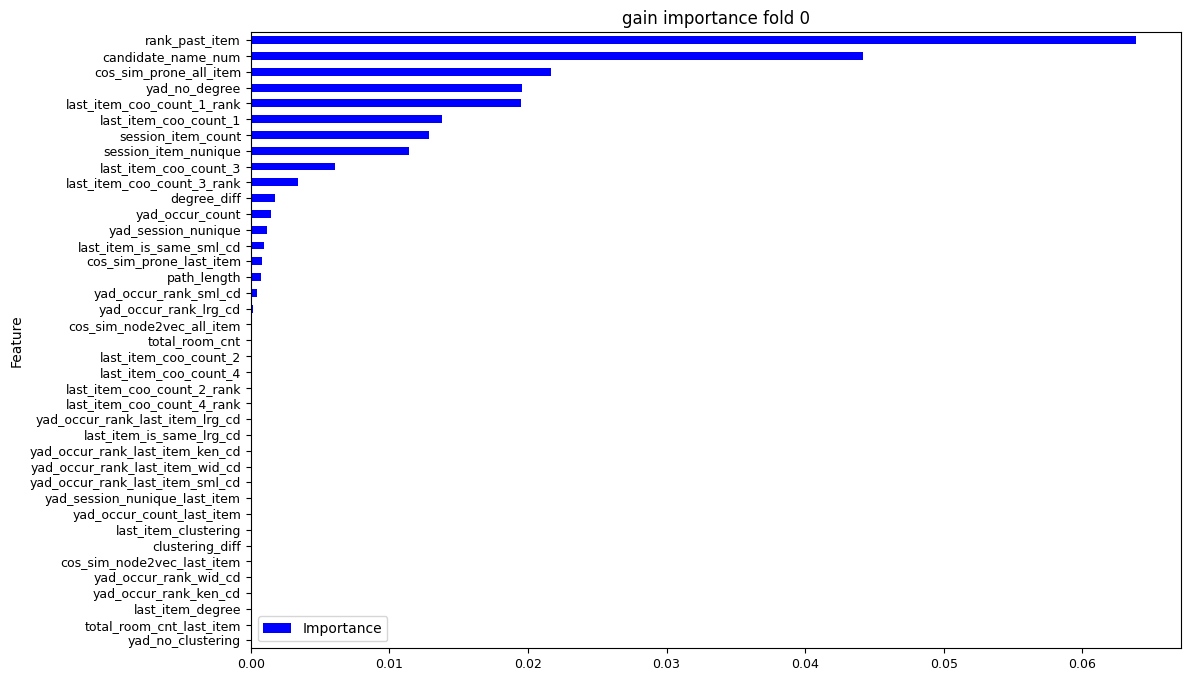

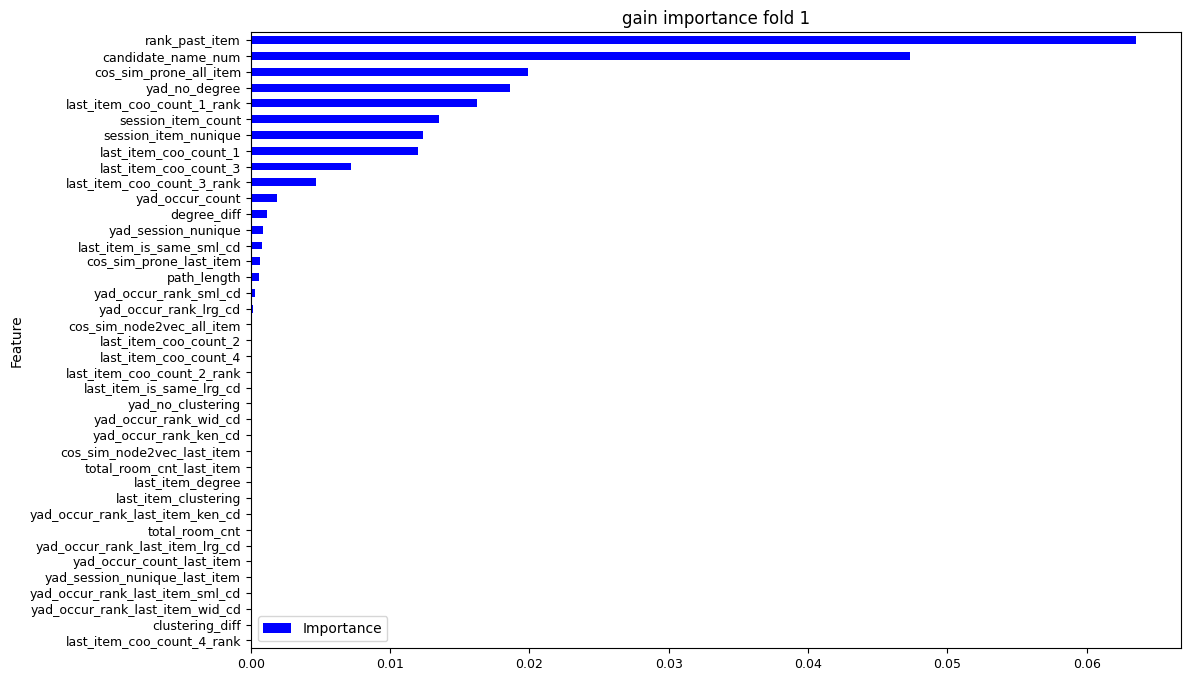

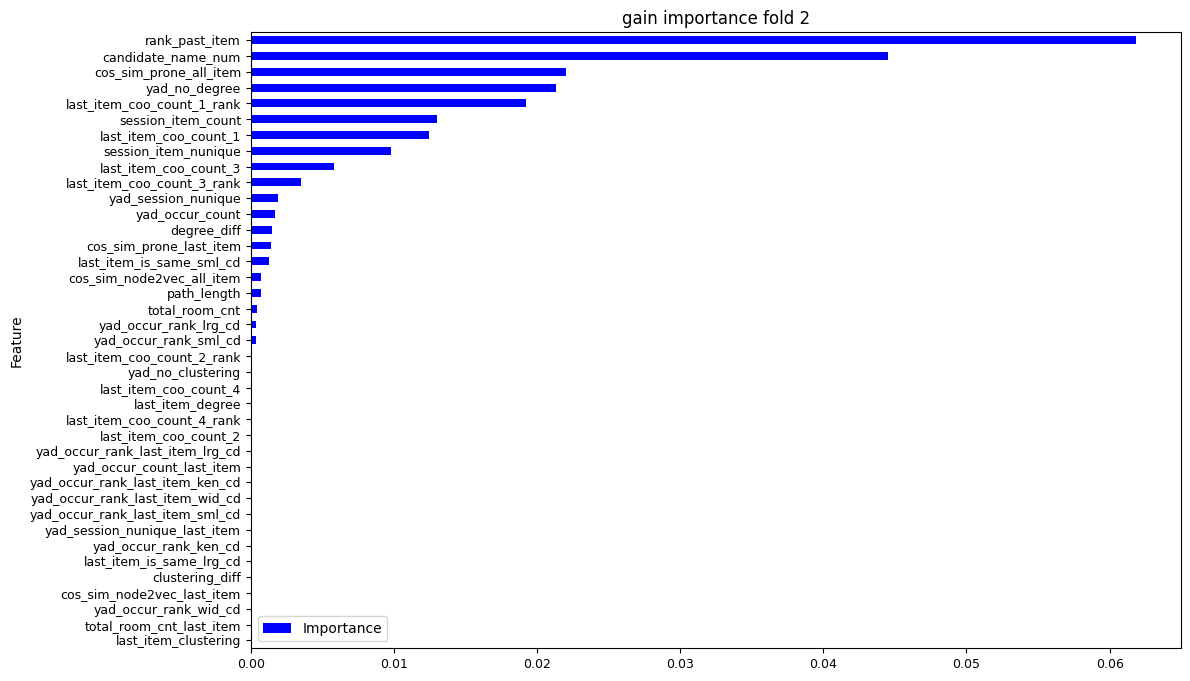

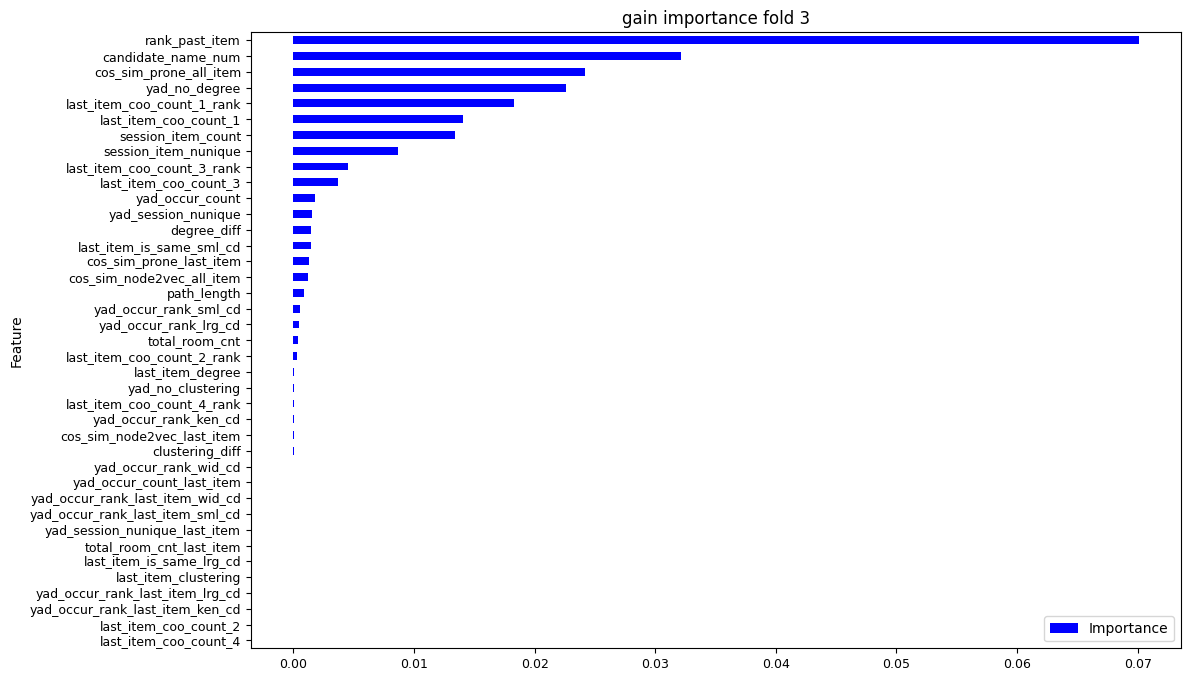

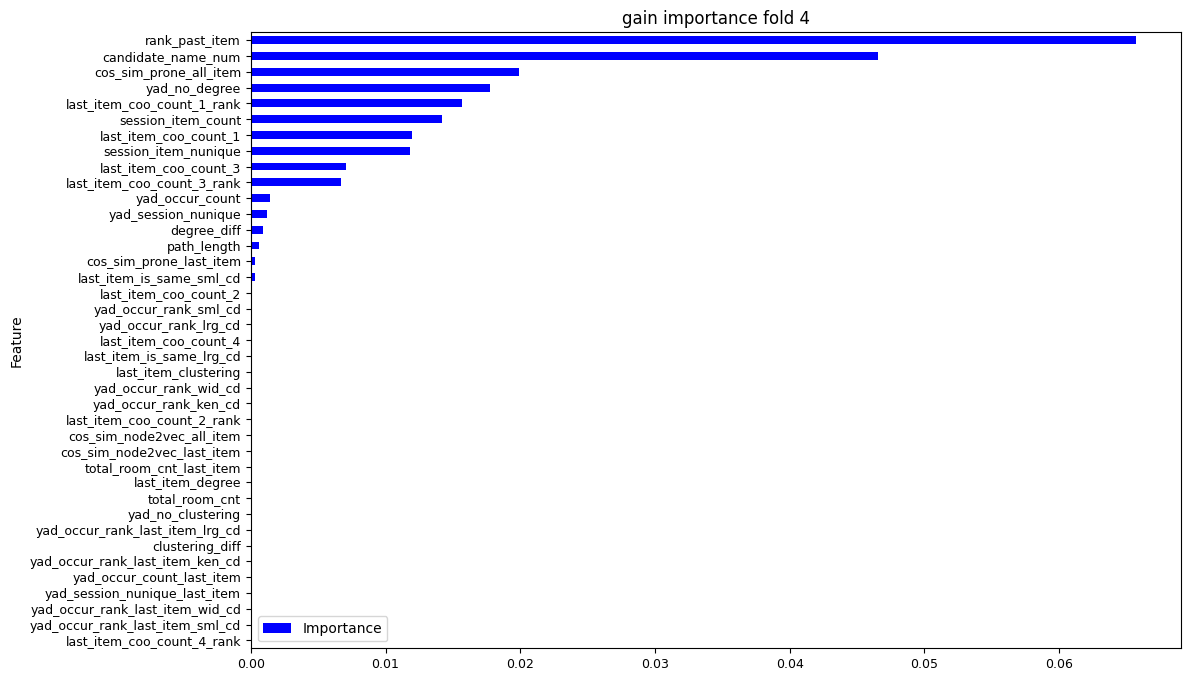

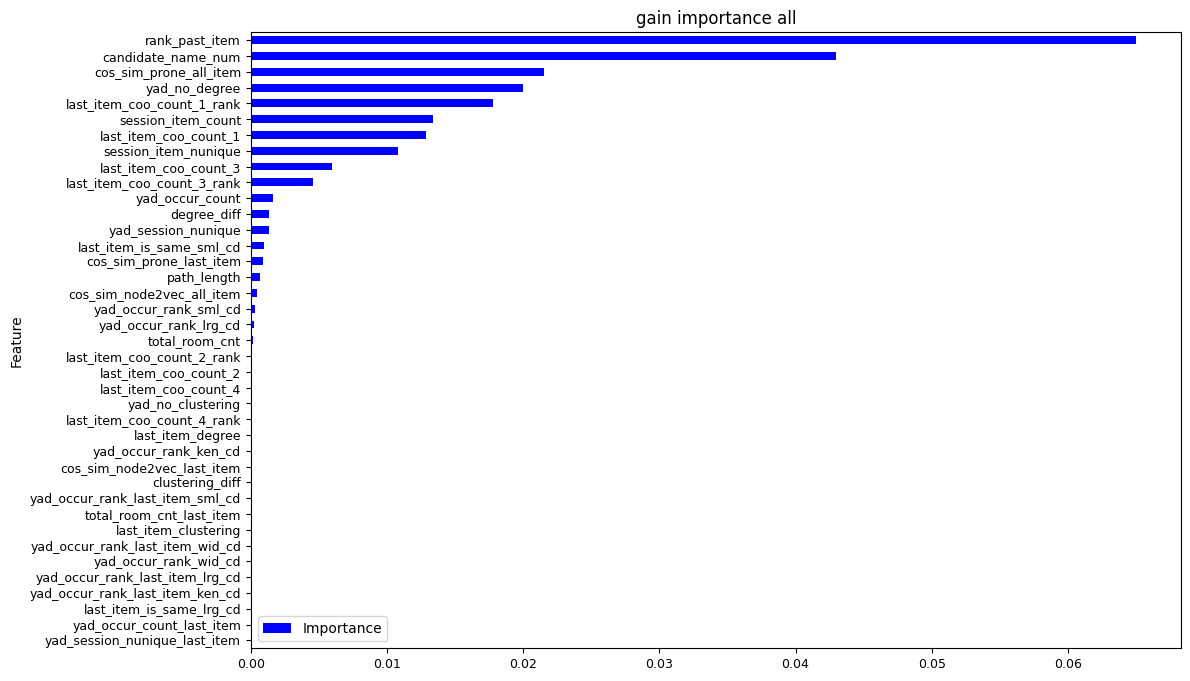

In [32]:
oof  = train(train_df, num_cols)

In [33]:
del train_df
gc.collect()

52991

## inference

In [34]:
test_df = pd.read_pickle(f'../../outputs/atmacup_16/{CFG.feature_notebook_name}/feature_pkl/test_df.pkl')

# test_df[num_cols] = reduce_mem_usage(test_df[num_cols])
gc.collect()

del_col = ['sml_cd', 'lrg_cd', 'sml_cd_last_item', 'lrg_cd_last_item', 'candidate_name']
test_df.drop(del_col, axis=1, inplace=True)
gc.collect()

test_null_df = test_df[num_cols].isnull().sum()
print(test_null_df)
test_null_df.to_csv(CFG.outputs_path + 'test_null.csv')

total_room_cnt                       795694
last_item_is_same_sml_cd                  0
last_item_is_same_lrg_cd                  0
rank_past_item                     14826805
yad_occur_count                      129438
yad_session_nunique                  129438
yad_occur_rank_sml_cd                     0
yad_occur_rank_wid_cd                     0
yad_occur_rank_ken_cd                     0
yad_occur_rank_lrg_cd                     0
session_item_count                        0
session_item_nunique                      0
last_item_coo_count_1                     0
last_item_coo_count_2                     0
last_item_coo_count_3                     0
last_item_coo_count_4                     0
last_item_coo_count_1_rank                0
last_item_coo_count_2_rank                0
last_item_coo_count_3_rank                0
last_item_coo_count_4_rank                0
cos_sim_node2vec_all_item                 0
cos_sim_node2vec_last_item                0
cos_sim_prone_all_item          

In [35]:
sub_oof = inference(test_df, num_cols)

inference fold 1
inference fold 2
inference fold 3
inference fold 4
inference fold 5


In [36]:
del test_df
gc.collect()

0

In [37]:
sub_oof.rename(columns={CFG.target_col: 'pred_0'}, inplace=True)

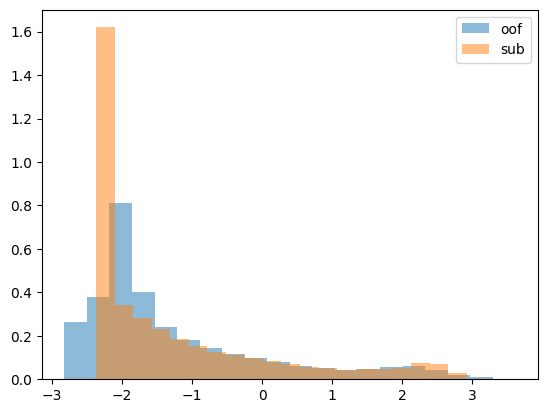

In [38]:
plt.hist(oof['pred_0'], density=True, alpha=0.5, label='oof', bins=20)
plt.hist(sub_oof['pred_0'], density=True, alpha=0.5, label='sub', bins=20)

plt.legend()
plt.show()

In [39]:
# sub_oof['session_id'] = test_df['session_id']
# sub_oof['yad_no'] = test_df['yad_no']

## 2stage用に残すもの  

最初にロードしたときのdfにあるcolumns 

past_itemのrank  
fold  
candidate_name  
pred (全部保存して、Rerankのときにsort→topkする)

In [40]:
remain_cols = ['session_id', 'yad_no',	'rank_past_item',	'candidate_name_num',
               'fold', 'pred_0', 'is_duplicated'] + list(set(['target', CFG.target_col]))
output_dir = CFG.outputs_path + 'oof/'
os.makedirs(output_dir, exist_ok=True)
oof = oof[remain_cols]
oof.to_pickle(output_dir + 'oof.pkl')

remain_cols = ['session_id', 'yad_no',	'rank_past_item',	'candidate_name_num',
               'pred_0']

sub_oof = sub_oof[remain_cols]
sub_oof[remain_cols].to_pickle(output_dir + 'sub_oof.pkl')

In [41]:
gc.collect()

6227

## sort

In [42]:
# use_cols = [col for col in oof.columns if col not in num_cols]
# oof = oof[use_cols]

In [43]:
# use_cols = [col for col in sub_oof.columns if col not in num_cols]
# sub_oof = sub_oof[use_cols]

In [44]:
oof = oof.sort_values(['session_id', 'pred_0'], ascending=[True, False]).reset_index(drop=True)
sub_oof = sub_oof.sort_values(['session_id', 'pred_0'], ascending=[True, False]).reset_index(drop=True)

# oof = oof.sort_values(['session_id', 'candidate_name_rank', 'pred_0'], ascending=[True, True, False]).reset_index(drop=True)
# sub_oof = sub_oof.sort_values(['session_id', 'candidate_name_rank', 'pred_0'], ascending=[True, True, False]).reset_index(drop=True)

In [45]:
def session_to_pred_list(session_df: pd.DataFrame, session_only_df: pd.DataFrame):
    pred_df = session_df.groupby('session_id')['yad_no'].apply(lambda x: x.tolist()).reset_index()
    pred_df = pd.merge(session_only_df, pred_df, on='session_id', how='left')

    pred_df['yad_no'] = pred_df['yad_no'].apply(lambda d: d if isinstance(d, list) else [])

    return pred_df['yad_no'].to_list()

In [46]:
train_pred_list = session_to_pred_list(oof, train_session_only_df)
test_pred_list = session_to_pred_list(sub_oof, test_session_only_df)

In [47]:
train_pred_list = [list(dict.fromkeys(pred)) for pred in train_pred_list]
test_pred_list = [list(dict.fromkeys(pred)) for pred in test_pred_list]

In [48]:
map_10 = mapk(train_label_df['yad_no'].to_list(), train_pred_list, k=10)
Logger.info(f'map10: {map_10}')

map10: 0.4056857418533807


In [49]:
def make_submission(test_pred_list):
    results = []
    cnts = []
    for pred in test_pred_list:
        
        pred = pred[:10]
        # print(pred)
        # pred = [int(p) for p in pred]
        
        cnt = len(pred)
        cnts.append(cnt)
        if cnt != 10:
            pred.extend([0] * (10 - cnt))
        results.append(pred)
    
    columns = [f'predict_{i}' for i in range(10)]
    submission = pd.DataFrame(results, columns=columns)

    plt.hist(cnts)
    return submission

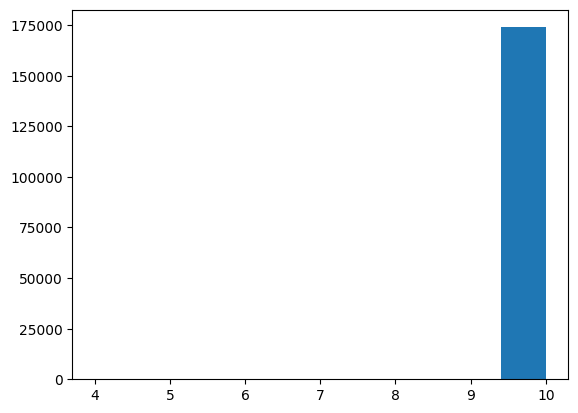

In [50]:
sub = make_submission(test_pred_list)

In [51]:
sub

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,5466,2680,4714,9534,4420,9830,6563,10233
1,4066,143,6555,613,7014,6129,8108,10095,11923,12862
2,757,9190,7710,9910,1774,13570,10485,6721,410,6862
3,12341,6991,3359,10861,13521,1542,4180,10746,5080,5657
4,9020,2862,10826,9623,5372,3854,3844,12029,763,3476
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,7062,5744,10997,9743,2278,11123,1885,831
174696,4014,1227,13220,899,3802,12432,2164,3644,6874,2232
174697,13241,13797,7379,844,13719,8143,11037,11796,12240,12939
174698,3100,3002,10287,2373,13672,5513,12281,4976,5515,11496


In [52]:
sub.to_csv(
    CFG.submission_dir + f'submission_{CFG.exp_name}.csv', index=False)

In [53]:
# sessionが変わるところで1行空けて、ログを見やすいようにする
def save_log_df(log_df):
    results = []
    prev_session_id = log_df.iloc[0]['session_id']
    for _, row in log_df.iterrows():
        session_id = row['session_id']
        if prev_session_id != session_id:
            results.append([np.nan]*len(log_df.columns))
        results.append(row.tolist())
        prev_session_id = session_id
    
    results = pd.DataFrame(results, columns=log_df.columns)

    return results

In [54]:
save_log_df(oof.head(10000)).to_csv(CFG.outputs_path + 'oof_1000.csv', index=False)

In [55]:
oof.sort_values(['yad_no', 'session_id', 'pred_0'], ascending=[True, True, False]).head(10000).to_csv(CFG.outputs_path + 'oof_1000_type2.csv', index=False)

## calc_recall

In [56]:
def calc_recall_k(train_df, train_label_df, k):
    session_to_true_yad = dict(zip(train_label_df['session_id'], train_label_df['yad_no']))

    train_df = train_df.groupby('session_id').head(k).reset_index(drop=True)
    print('train_df len', len(train_df))

    session_to_yad_dict = train_df.groupby('session_id')['yad_no'].apply(list).to_dict()

    cnt = 0
    total_cnt = 0
    # for session_id, grp_df in train_df.groupby('session_id'):
    for session_id, yads in session_to_yad_dict.items():
        # yads = set(grp_df['yad_no'].unique())
        yads = set(yads)
        true_yad = session_to_true_yad[session_id]

        if true_yad in yads:
            cnt += 1
        
        total_cnt += 1
    
    recall_num = cnt / total_cnt
    return recall_num

In [57]:
for k in [100, 50, 40, 30, 20, 10]:
    recall_num = calc_recall_k(oof, train_label_df, k)
    Logger.info(f'recall@{k}: {recall_num}')

train_df len 21297894


recall@100: 0.945825741778606


train_df len 13427188


recall@50: 0.8934803843462719


train_df len 11100694


recall@40: 0.8648102861814075


train_df len 8526214


recall@30: 0.8200507104309693


train_df len 5744454


recall@20: 0.7448198463446231


train_df len 2884349


recall@10: 0.6101323874775717
